In [37]:
import pandas as pd
from sklearn import preprocessing, metrics
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
import matplotlib.pylab as plt
from sklearn.model_selection import train_test_split,GridSearchCV, cross_val_score
from sklearn.preprocessing import MinMaxScaler,LabelEncoder,StandardScaler,Normalizer,OneHotEncoder,RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score,accuracy_score,roc_auc_score,precision_recall_fscore_support,matthews_corrcoef
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
import seaborn as sns
from sklearn.metrics import roc_curve,auc,confusion_matrix
import itertools
import numpy as np

In [38]:
from dmba import regressionSummary, exhaustive_search
from dmba import backward_elimination, forward_selection, stepwise_selection
from dmba import adjusted_r2_score, AIC_score, BIC_score
from dmba import classificationSummary, gainsChart, liftChart, plotDecisionTree

In [39]:
data = pd.read_csv('encoded_data.csv')
data.shape
#data.info()

(92359, 55)

In [40]:
X = data.drop('Score',axis=1)
y = data.Score.values

In [41]:
#splitting of the data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33, random_state=42)

# **Random Forest Classifier**

In [42]:
#param grid
#we have limit max_depth to 10 so that the model doesn't overfit
param = { 'min_samples_split':[5,10,30,50,100],'max_depth':[5,7,10]}

#Random forest classifier
RFclf = RandomForestClassifier(class_weight='balanced')

#using grid search cv to tune parameters
RF = GridSearchCV(RFclf,param,cv= None,refit=False,n_jobs=-1,verbose=1,
                  return_train_score=True,scoring='roc_auc')
RF.fit(X_train,y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


GridSearchCV(estimator=RandomForestClassifier(class_weight='balanced'),
             n_jobs=-1,
             param_grid={'max_depth': [5, 7, 10],
                         'min_samples_split': [5, 10, 30, 50, 100]},
             refit=False, return_train_score=True, scoring='roc_auc',
             verbose=1)

In [43]:
RF.best_params_

{'max_depth': 10, 'min_samples_split': 5}

In [44]:
RFclf = RandomForestClassifier(max_depth = 10, min_samples_split = 10,
                            class_weight = 'balanced',n_estimators=500, random_state=1,
                            criterion='gini')
RFclf.fit(X_train, y_train)

# variable (feature) importance plot
importances = RFclf.feature_importances_
std = np.std([tree.feature_importances_ for tree in RFclf.estimators_], axis=0) 

df = pd.DataFrame({'feature': X_train.columns, 'importance': importances, 'std': std})
df = df.sort_values('importance', ascending = False)
print(df)

                       feature  importance       std
11                arrival_time    0.153122  0.143497
8                delivery_days    0.126959  0.127699
13           existing_customer    0.124267  0.052311
43       delivery_impression_0    0.096492  0.130796
0                payment_value    0.067017  0.026890
45       delivery_impression_2    0.065343  0.093254
2                        price    0.038492  0.026372
3                freight_value    0.031182  0.011465
15               freight_ratio    0.029137  0.012486
9               estimated_days    0.027007  0.009725
14                    distance    0.025162  0.009307
12           seller_popularity    0.020601  0.006440
5   product_description_lenght    0.020081  0.005965
1                order_item_id    0.018423  0.005708
16                        size    0.018263  0.005708
7             product_weight_g    0.018057  0.005999
44       delivery_impression_1    0.015645  0.018439
4          product_name_lenght    0.014552  0.

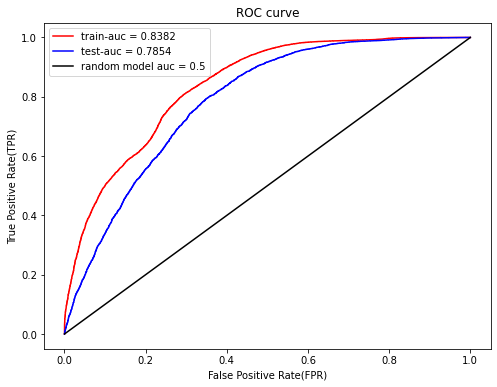

Best AUC for the model is 0.7854 


In [9]:
#predicted value of y probabilities
y_pred_train = RFclf.predict_proba(X_train)
y_pred_test = RFclf.predict_proba(X_test)

#predicted values of Y labels
pred_label_train = RFclf.predict(X_train)
pred_label_test = RFclf.predict(X_test)

#Confusion Matrix
cf_matrix_train = confusion_matrix(y_train,pred_label_train)
cf_matrix_test = confusion_matrix(y_test,pred_label_test)

fpr_train,tpr_train,threshold_train = roc_curve(y_train,y_pred_train[:,1])
fpr_test,tpr_test,threshold_test = roc_curve(y_test,y_pred_test[:,1])

train_auc = round(auc(fpr_train,tpr_train),4)
test_auc = round(auc(fpr_test,tpr_test),4)

%matplotlib inline
plt.figure(figsize=(8,6))
plt.plot(fpr_train,tpr_train,color='red',label='train-auc = '+str(train_auc))
plt.plot(fpr_test,tpr_test,color='blue',label='test-auc = '+str(test_auc))
plt.plot(np.array([0,1]),np.array([0,1]),color='black',label='random model auc = '+str(0.5))
plt.xlabel('False Positive Rate(FPR)')
plt.ylabel('True Positive Rate(TPR)')
plt.title('ROC curve')
plt.legend()
plt.show()
print('Best AUC for the model is {} '.format(test_auc))

In [10]:
RF_pred = RFclf.predict(X_test)
RF_proba = RFclf.predict_proba(X_test)
RF_result = pd.DataFrame({'actual': y_test, 
                             'p(0)': [p[0] for p in RF_proba],
                             'p(1)': [p[1] for p in RF_proba],
                             'predicted': RF_pred })
RF_result.head(10)

,actual,p(0),p(1),predicted
0,0.0,0.744924,0.255076,0.0
1,1.0,0.439652,0.560348,1.0
2,1.0,0.385082,0.614918,1.0
3,1.0,0.932293,0.067707,0.0
4,1.0,0.296424,0.703576,1.0
5,1.0,0.316371,0.683629,1.0
6,0.0,0.945983,0.054017,0.0
7,1.0,0.285223,0.714777,1.0
8,1.0,0.314304,0.685696,1.0
9,1.0,0.402710,0.597290,1.0


**LiftChart and GainsChart**

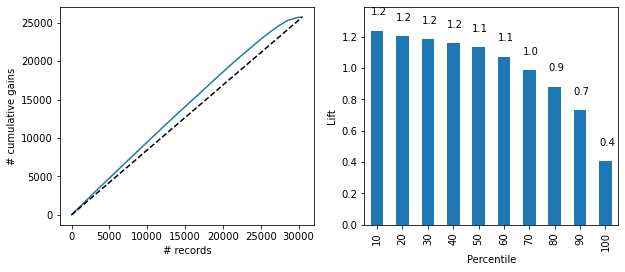

In [11]:
df = RF_result.sort_values(by=['p(1)'], ascending=False)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
gainsChart(df.actual, ax=axes[0])
liftChart(df['p(1)'], title=False, ax=axes[1])
plt.show()

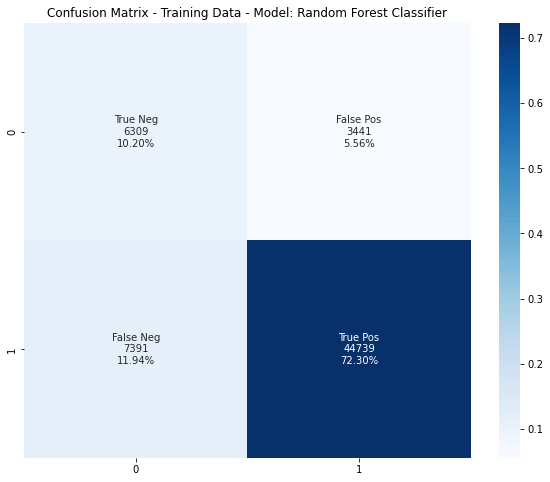

In [12]:
plt.figure(figsize=(10,8))
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix_train.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix_train.flatten()/np.sum(cf_matrix_train)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix_train/np.sum(cf_matrix_train), annot= labels ,fmt= '', cmap='Blues')
plt.title('Confusion Matrix - Training Data - Model: Random Forest Classifier')
plt.show()

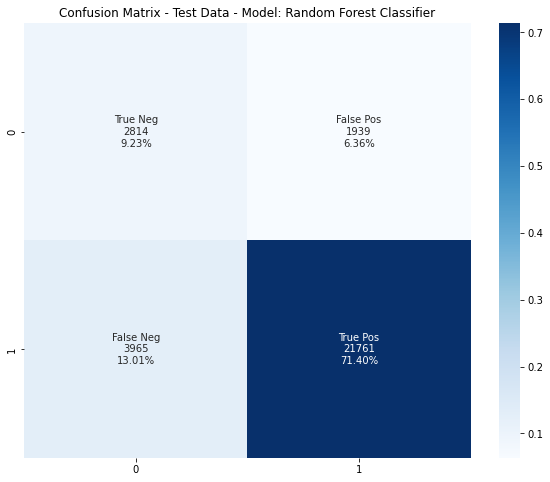

In [13]:
plt.figure(figsize=(10,8))
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix_test.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix_test.flatten()/np.sum(cf_matrix_test)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix_test/np.sum(cf_matrix_test), annot= labels ,fmt= '', cmap='Blues')
plt.title('Confusion Matrix - Test Data - Model: Random Forest Classifier')
plt.show()

In [14]:
regressionSummary(y_train, RFclf.predict(X_train))


Regression statistics

               Mean Error (ME) : 0.0638
Root Mean Squared Error (RMSE) : 0.4184
     Mean Absolute Error (MAE) : 0.1750


In [15]:
print('F1 Score = ',round(f1_score(y_test, np.round(RFclf.predict(X_test),0), average='micro'),5))

F1 Score =  0.80629


In [16]:
print('AIC', AIC_score(y_test, RFclf.predict(X_test), df = len(X_train.columns) + 1))

AIC 36579.18571683163


In [45]:
matthews_corrcoef(y_test, RFclf.predict(X_test))

0.38204164092546244

# **Boosted Trees**

In [46]:
boost = GradientBoostingClassifier()
boost.fit(X_train, y_train)

GradientBoostingClassifier()

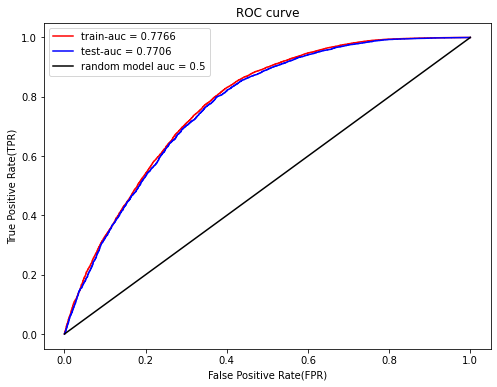

Best AUC for the model is 0.7706 


In [18]:
#predicted value of y probabilities
y_pred_train = boost.predict_proba(X_train)
y_pred_test = boost.predict_proba(X_test)

#predicted values of Y labels
pred_label_train = boost.predict(X_train)
pred_label_test = boost.predict(X_test)

#Confusion Matrix
cf_matrix_train = confusion_matrix(y_train,pred_label_train)
cf_matrix_test = confusion_matrix(y_test,pred_label_test)

fpr_train,tpr_train,threshold_train = roc_curve(y_train,y_pred_train[:,1])
fpr_test,tpr_test,threshold_test = roc_curve(y_test,y_pred_test[:,1])

train_auc = round(auc(fpr_train,tpr_train),4)
test_auc = round(auc(fpr_test,tpr_test),4)

%matplotlib inline
plt.figure(figsize=(8,6))
plt.plot(fpr_train,tpr_train,color='red',label='train-auc = '+str(train_auc))
plt.plot(fpr_test,tpr_test,color='blue',label='test-auc = '+str(test_auc))
plt.plot(np.array([0,1]),np.array([0,1]),color='black',label='random model auc = '+str(0.5))
plt.xlabel('False Positive Rate(FPR)')
plt.ylabel('True Positive Rate(TPR)')
plt.title('ROC curve')
plt.legend()
plt.show()
print('Best AUC for the model is {} '.format(test_auc))

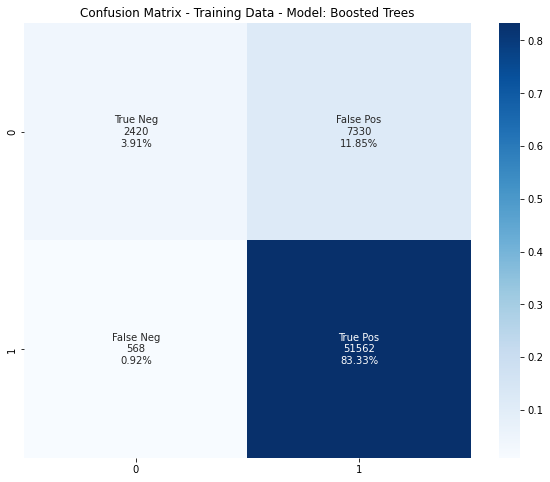

In [19]:
plt.figure(figsize=(10,8))
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix_train.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix_train.flatten()/np.sum(cf_matrix_train)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix_train/np.sum(cf_matrix_train), annot= labels ,fmt= '', cmap='Blues')
plt.title('Confusion Matrix - Training Data - Model: Boosted Trees')
plt.show()

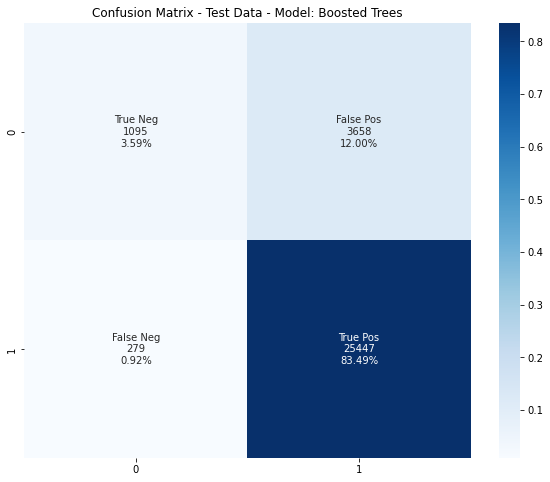

In [20]:
plt.figure(figsize=(10,8))
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix_test.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix_test.flatten()/np.sum(cf_matrix_test)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix_test/np.sum(cf_matrix_test), annot= labels ,fmt= '', cmap='Blues')
plt.title('Confusion Matrix - Test Data - Model: Boosted Trees')
plt.show()

In [21]:
boost_pred = boost.predict(X_test)
boost_proba = boost.predict_proba(X_test)
boost_result = pd.DataFrame({'actual': y_test, 
                             'p(0)': [p[0] for p in boost_proba],
                             'p(1)': [p[1] for p in boost_proba],
                             'predicted': boost_pred })
boost_result.head(10)

,actual,p(0),p(1),predicted
0,0.0,0.260751,0.739249,1.0
1,1.0,0.108598,0.891402,1.0
2,1.0,0.118866,0.881134,1.0
3,1.0,0.890849,0.109151,0.0
4,1.0,0.062364,0.937636,1.0
5,1.0,0.083333,0.916667,1.0
6,0.0,0.809951,0.190049,0.0
7,1.0,0.077220,0.922780,1.0
8,1.0,0.080663,0.919337,1.0
9,1.0,0.088834,0.911166,1.0


In [52]:
boost_result.to_csv('boost_result.csv',index=False)

**LiftChart and GainsChart**

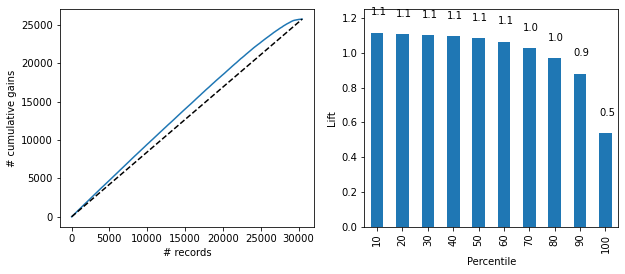

In [22]:
df = boost_result.sort_values(by=['p(1)'], ascending=False)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
gainsChart(df.actual, ax=axes[0])
liftChart(df['p(1)'], title=False, ax=axes[1])
plt.show()

In [23]:
regressionSummary(y_train, boost.predict(X_train))


Regression statistics

               Mean Error (ME) : -0.1093
Root Mean Squared Error (RMSE) : 0.3573
     Mean Absolute Error (MAE) : 0.1276


In [24]:
print('F1 Score = ',round(f1_score(y_test, np.round(boost.predict(X_test),0), average='micro'),5))

F1 Score =  0.87083


In [25]:
print('AIC', AIC_score(y_test, boost.predict(X_test), df = len(X_train.columns) + 1))

AIC 24228.75735164828


In [47]:
matthews_corrcoef(y_test, boost.predict(X_test))

0.38388233633810614

# **Descision Tree**

In [48]:
#model initialize
DT = DecisionTreeClassifier(class_weight='balanced')

#hyper parameters
param = {'max_depth':  [1, 5,10,15,20], 'min_samples_split': [5, 10, 100, 300,500,1000],
        'min_impurity_decrease': [0, 0.0005, 0.001, 0.005, 0.01,0.05]}

#Grid search CV
DT = GridSearchCV(DT,param,cv = None,refit=False,return_train_score=True,scoring='roc_auc')
DT.fit(X_train,y_train)

GridSearchCV(estimator=DecisionTreeClassifier(class_weight='balanced'),
             param_grid={'max_depth': [1, 5, 10, 15, 20],
                         'min_impurity_decrease': [0, 0.0005, 0.001, 0.005,
                                                   0.01, 0.05],
                         'min_samples_split': [5, 10, 100, 300, 500, 1000]},
             refit=False, return_train_score=True, scoring='roc_auc')

In [49]:
#best params
DT.best_params_

{'max_depth': 10, 'min_impurity_decrease': 0, 'min_samples_split': 1000}

In [50]:
DTclf = DecisionTreeClassifier(max_depth = 10, min_samples_split = 1000, min_impurity_decrease = 0,
                            class_weight = 'balanced', random_state=1,
                            criterion='gini')
DTclf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=10,
                       min_impurity_decrease=0, min_samples_split=1000,
                       random_state=1)

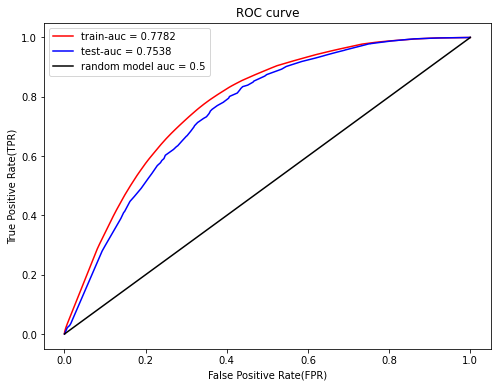

Best AUC for the model is 0.7538 


In [29]:
#predicted value of y probabilities
y_pred_train = DTclf.predict_proba(X_train)
y_pred_test = DTclf.predict_proba(X_test)

#predicted values of Y labels
pred_label_train = DTclf.predict(X_train)
pred_label_test = DTclf.predict(X_test)

#Confusion Matrix
cf_matrix_train = confusion_matrix(y_train,pred_label_train)
cf_matrix_test = confusion_matrix(y_test,pred_label_test)

fpr_train,tpr_train,threshold_train = roc_curve(y_train,y_pred_train[:,1])
fpr_test,tpr_test,threshold_test = roc_curve(y_test,y_pred_test[:,1])

train_auc = round(auc(fpr_train,tpr_train),4)
test_auc = round(auc(fpr_test,tpr_test),4)

%matplotlib inline
plt.figure(figsize=(8,6))
plt.plot(fpr_train,tpr_train,color='red',label='train-auc = '+str(train_auc))
plt.plot(fpr_test,tpr_test,color='blue',label='test-auc = '+str(test_auc))
plt.plot(np.array([0,1]),np.array([0,1]),color='black',label='random model auc = '+str(0.5))
plt.xlabel('False Positive Rate(FPR)')
plt.ylabel('True Positive Rate(TPR)')
plt.title('ROC curve')
plt.legend()
plt.show()
print('Best AUC for the model is {} '.format(test_auc))

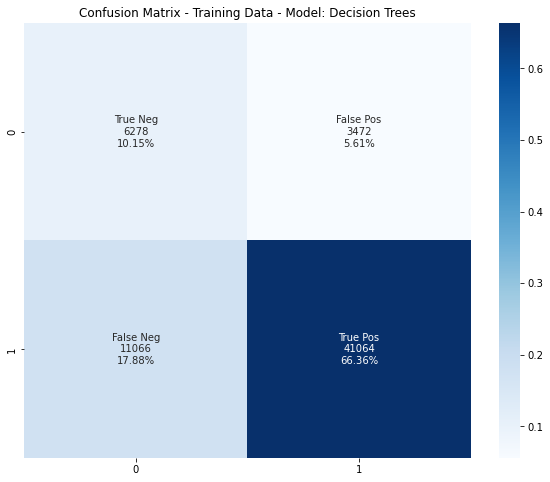

In [30]:
plt.figure(figsize=(10,8))
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix_train.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix_train.flatten()/np.sum(cf_matrix_train)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix_train/np.sum(cf_matrix_train), annot= labels ,fmt= '', cmap='Blues')
plt.title('Confusion Matrix - Training Data - Model: Decision Trees')
plt.show()

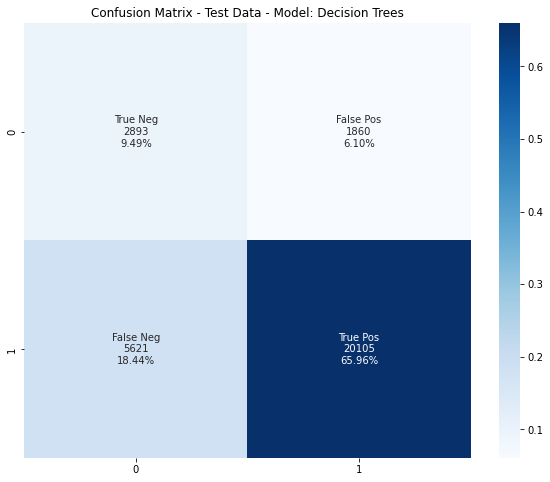

In [31]:
plt.figure(figsize=(10,8))
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix_test.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix_test.flatten()/np.sum(cf_matrix_test)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix_test/np.sum(cf_matrix_test), annot= labels ,fmt= '', cmap='Blues')
plt.title('Confusion Matrix - Test Data - Model: Decision Trees')
plt.show()

In [32]:
DT_pred = DTclf.predict(X_test)
DT_proba = DTclf.predict_proba(X_test)
DT_result = pd.DataFrame({'actual': y_test, 
                             'p(0)': [p[0] for p in DT_proba],
                             'p(1)': [p[1] for p in DT_proba],
                             'predicted': DT_pred })
DT_result.head(10)

,actual,p(0),p(1),predicted
0,0.0,0.586521,0.413479,0.0
1,1.0,0.395372,0.604628,1.0
2,1.0,0.522250,0.477750,0.0
3,1.0,0.934354,0.065646,0.0
4,1.0,0.226355,0.773645,1.0
5,1.0,0.264533,0.735467,1.0
6,0.0,0.980157,0.019843,0.0
7,1.0,0.264533,0.735467,1.0
8,1.0,0.264533,0.735467,1.0
9,1.0,0.395372,0.604628,1.0


**GainsChart and LiftChart**

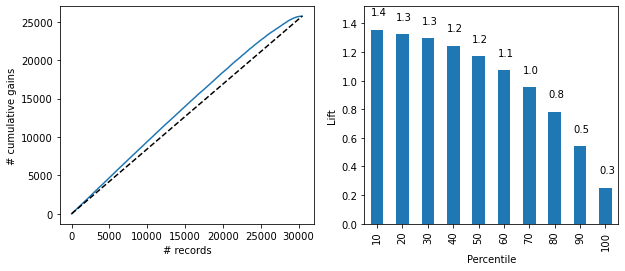

In [33]:
df = DT_result.sort_values(by=['p(1)'], ascending=False)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
gainsChart(df.actual, ax=axes[0])
liftChart(df['p(1)'], title=False, ax=axes[1])
plt.show()

In [34]:
regressionSummary(y_train, DTclf.predict(X_train))


Regression statistics

               Mean Error (ME) : 0.1227
Root Mean Squared Error (RMSE) : 0.4847
     Mean Absolute Error (MAE) : 0.2349


In [35]:
print('F1 Score = ',round(f1_score(y_test, np.round(DTclf.predict(X_test),0), average='micro'),5))

F1 Score =  0.75455


In [36]:
print('AIC', AIC_score(y_test, DTclf.predict(X_test), df = len(X_train.columns) + 1))

AIC 43794.67401329314


In [51]:
matthews_corrcoef(y_test, DTclf.predict(X_test))

0.3154969475342457

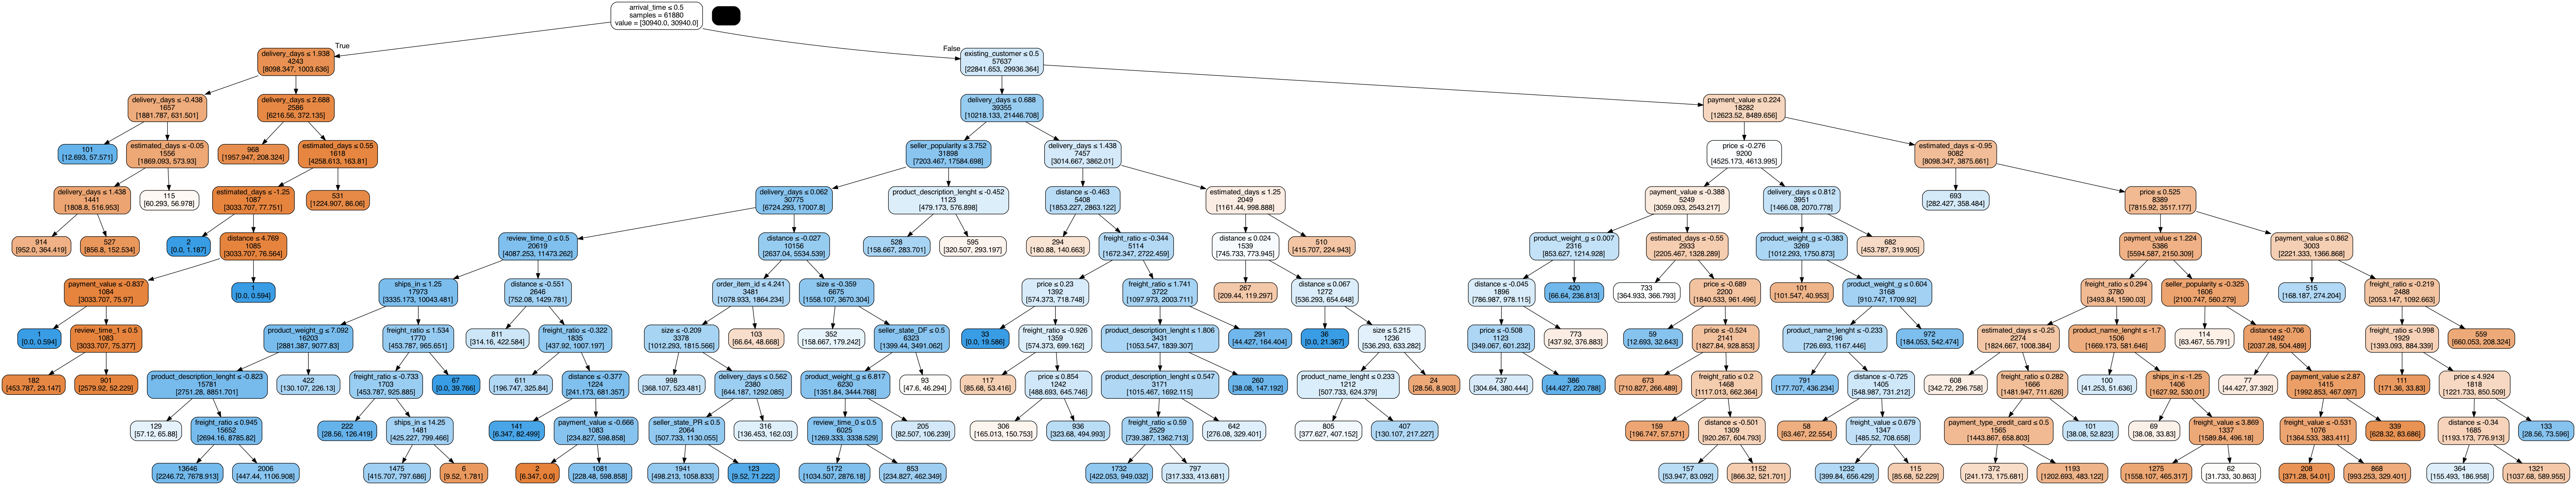

In [49]:
plotDecisionTree(DTclf, feature_names=X_train.columns)